# Import Libraries

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2025-07-14 03:44:52.493020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752464692.518475     346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752464692.526464     346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the data: the Cats vs Dogs dataset


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   218M      0  0:00:03  0:00:03 --:--:--  218M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
 CDLA-Permissive-2.0.pdf      model.png  'readme[1].txt'
 kagglecatsanddogs_5340.zip   PetImages


In [4]:
!ls PetImages


Cat  Dog


  #    Filter out corrupted images


In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# Generate a Dataset


In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


I0000 00:00:1752464833.672494     346 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752464833.673238     346 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Visualize the data


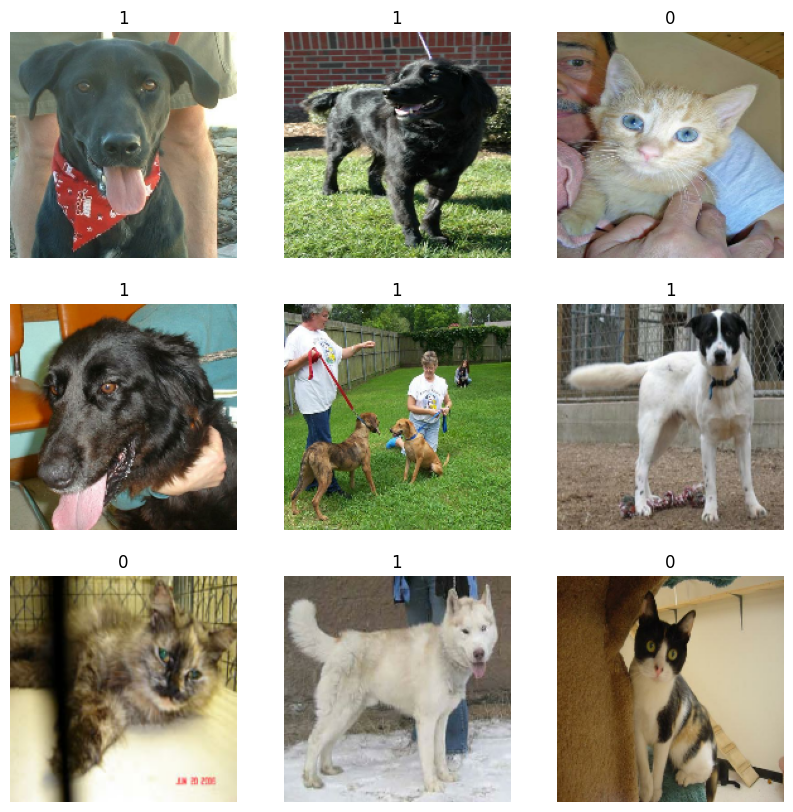

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Auhgmentation

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

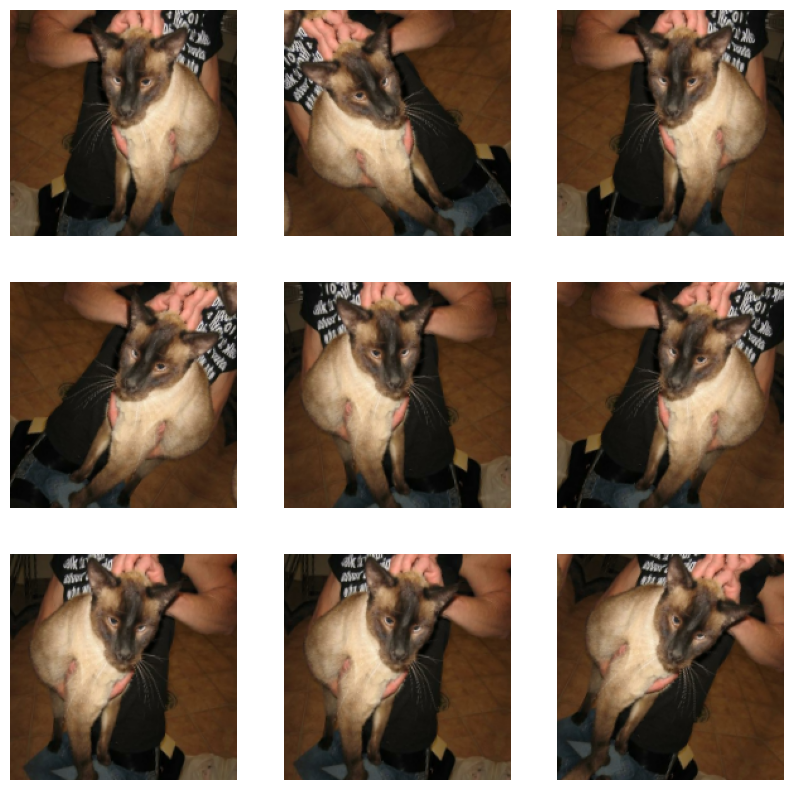

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

[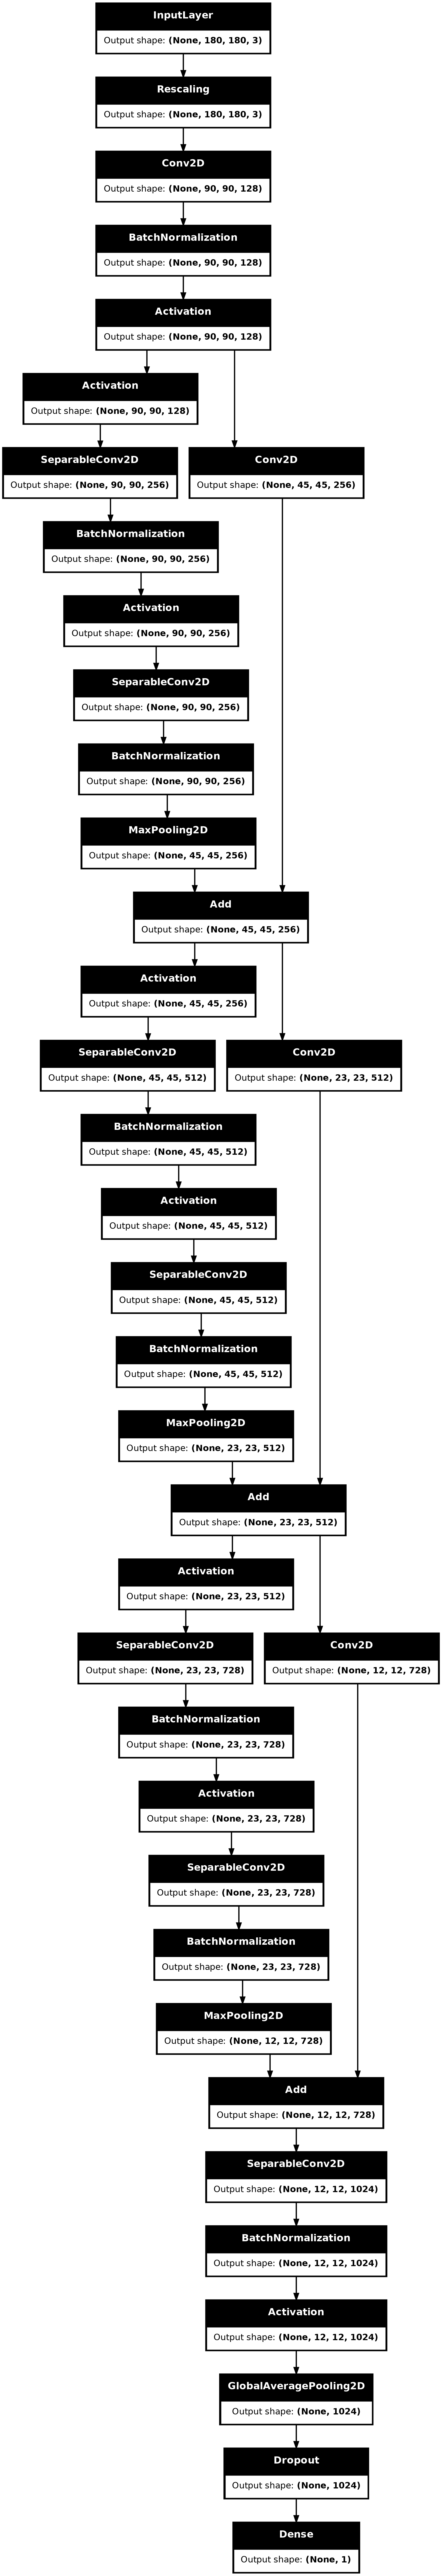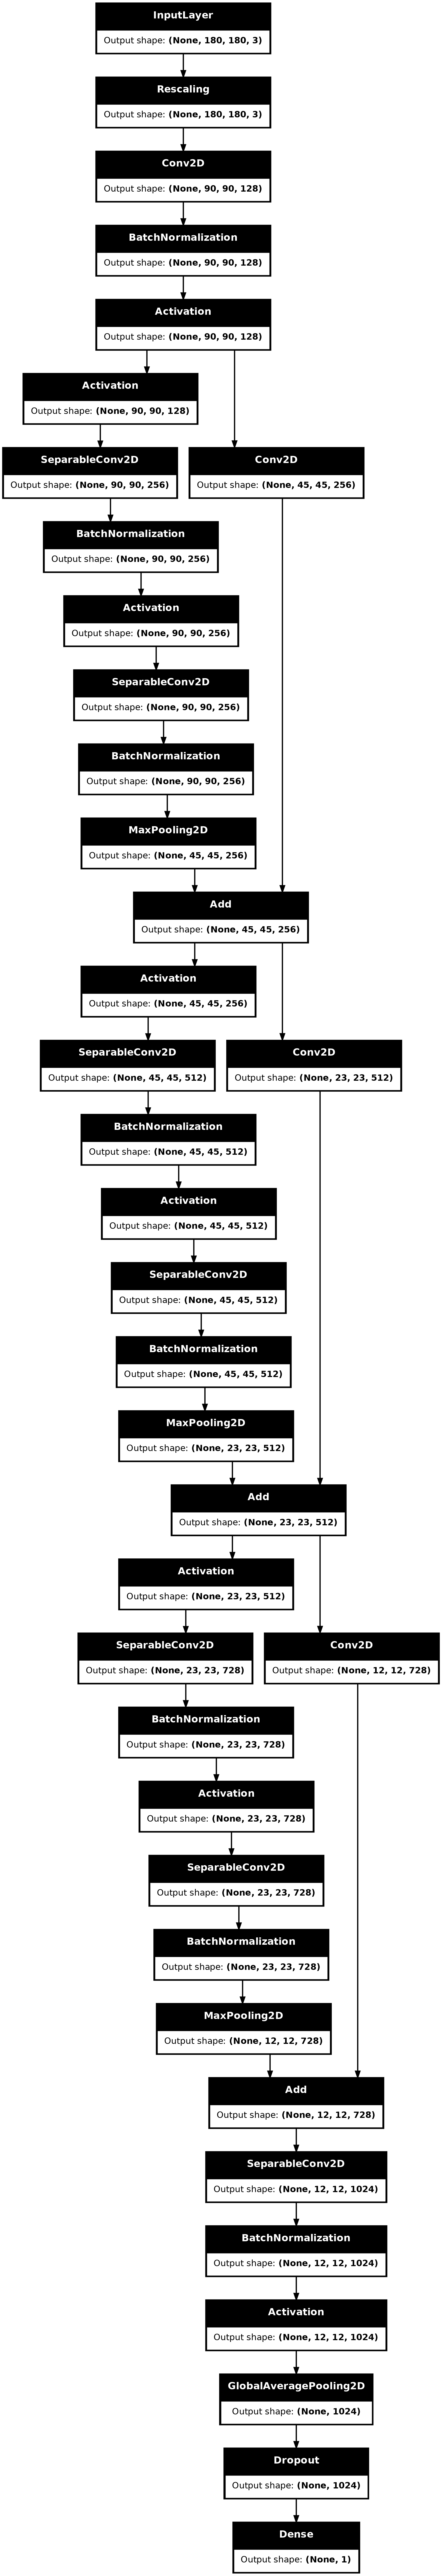](http://)
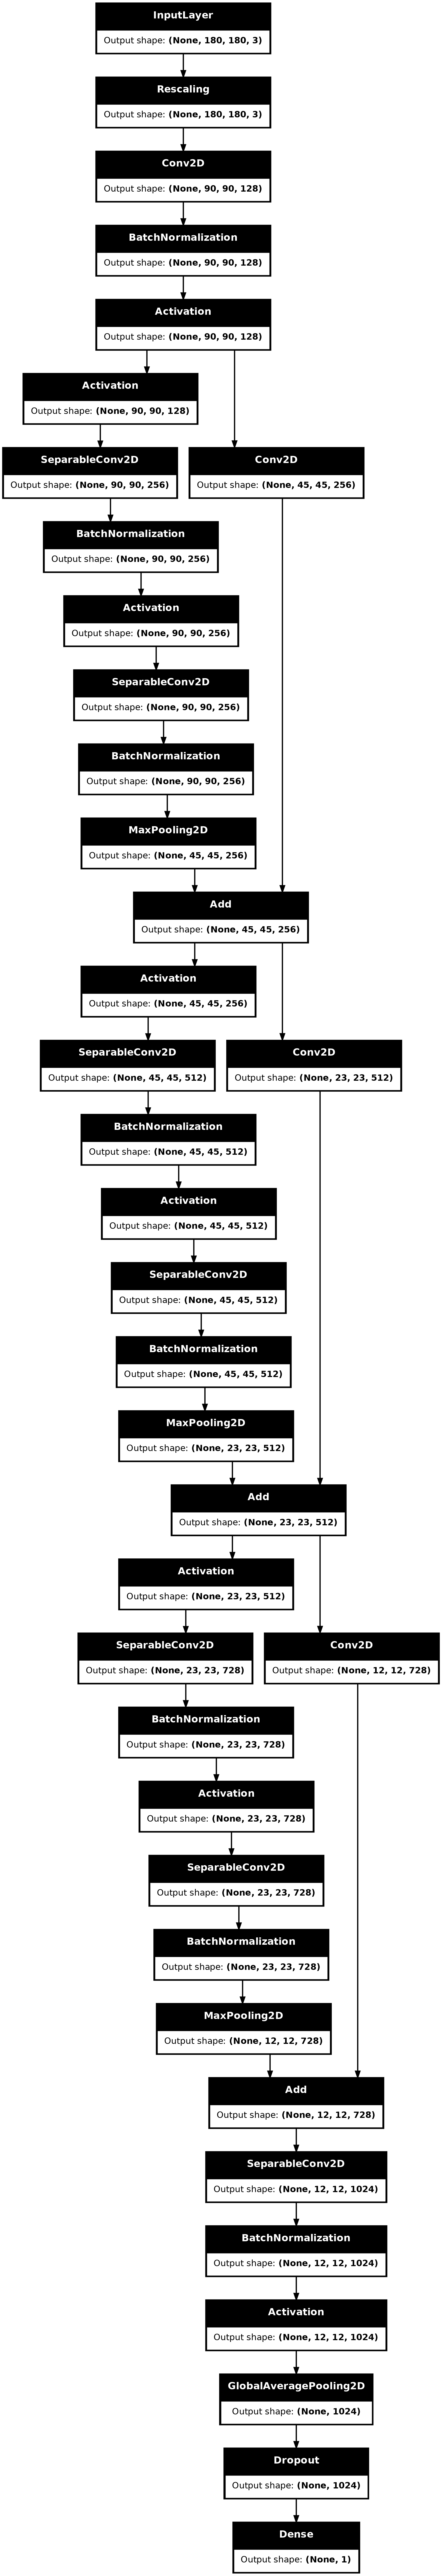
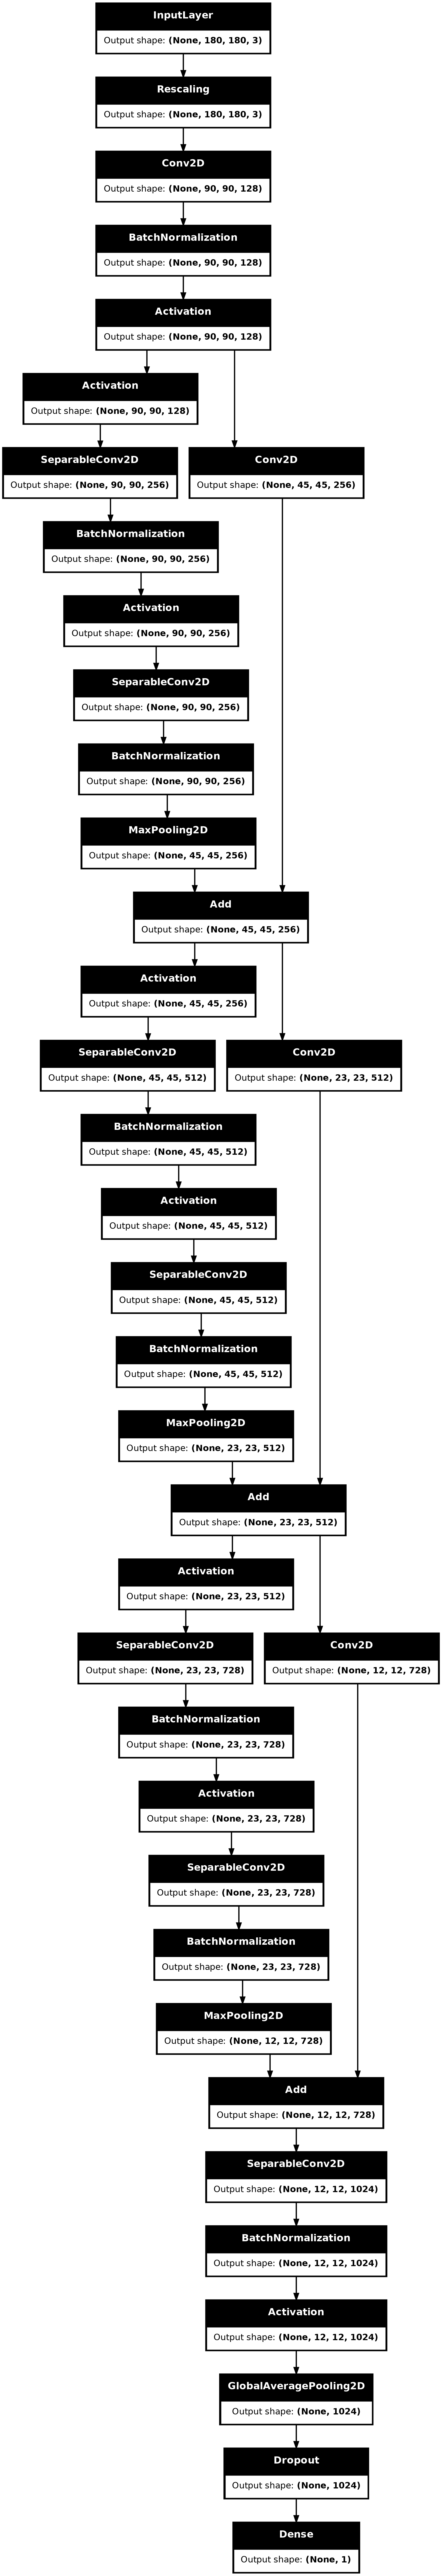

# Build a model


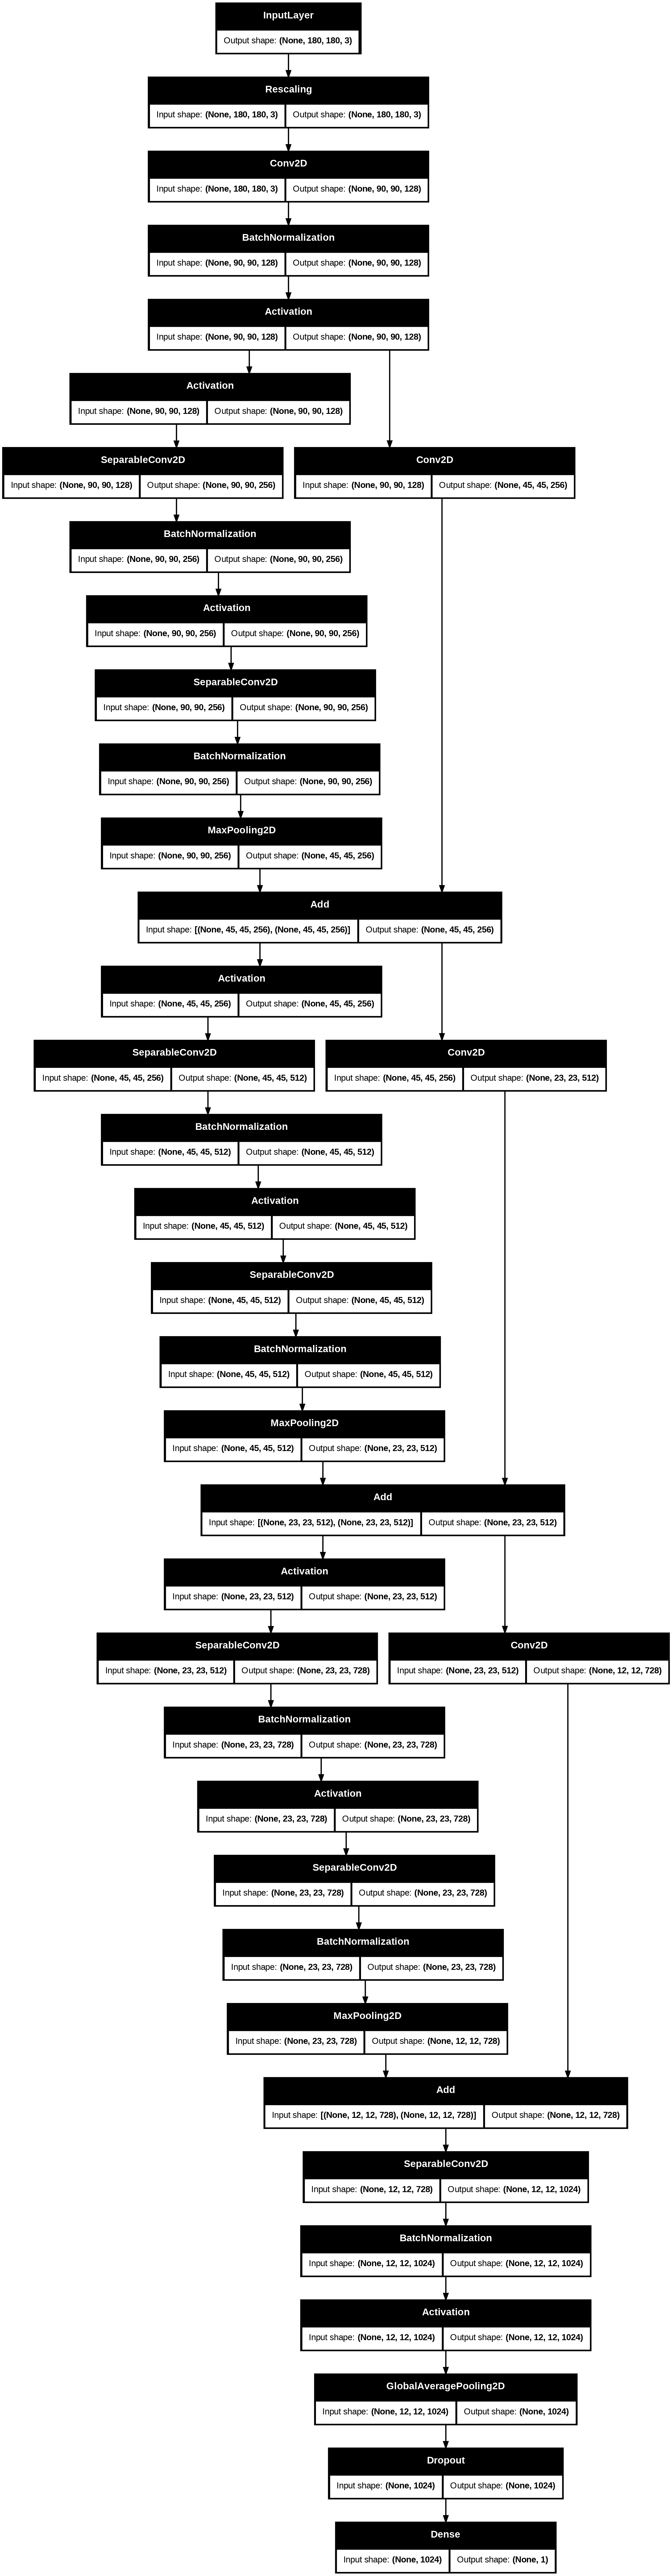

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model


In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


I0000 00:00:1752464853.013180     393 service.cc:148] XLA service 0x7fcc7c003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752464853.013230     393 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752464853.013236     393 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
I0000 00:00:1752464854.632090     393 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-14 03:47:47.478780: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[128,512,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,45,45]{3,2,1,0}, f32[512,512,1,1]{3,2,1,0}, f32[512]{0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_

 68/147 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - acc: 0.6049 - loss: 0.6663

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.6080 - loss: 0.6628

 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.6151 - loss: 0.6549

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - acc: 0.6165 - loss: 0.6533 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/147 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - acc: 0.6236 - loss: 0.6457

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


146/147 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.6305 - loss: 0.6381

E0000 00:00:1752465147.146782     392 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752465147.555065     392 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-14 03:52:27.724773: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[256,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,256,90,90]{3,2,1,0}, f32[40,256,90,90]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=256, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a whi

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.6307 - loss: 0.6378

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - acc: 0.6310 - loss: 0.6375 - val_acc: 0.4957 - val_loss: 0.6930
Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/147 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - acc: 0.7472 - loss: 0.5003

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 79/147 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - acc: 0.7473 - loss: 0.5001

 99/147 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - acc: 0.7500 - loss: 0.4952

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - acc: 0.7502 - loss: 0.4947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.7509 - loss: 0.4935

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7564 - loss: 0.4848

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - acc: 0.7565 - loss: 0.4846 - val_acc: 0.4957 - val_loss: 0.6963
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - acc: 0.8187 - loss: 0.3942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - acc: 0.8201 - loss: 0.3911

102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.8204 - loss: 0.3903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.8205 - loss: 0.3901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/147 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - acc: 0.8207 - loss: 0.3896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


118/147 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - acc: 0.8211 - loss: 0.3885

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8225 - loss: 0.3849

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.8226 - loss: 0.3848 - val_acc: 0.5000 - val_loss: 0.6979
Epoch 4/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/147 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - acc: 0.8464 - loss: 0.3299

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - acc: 0.8468 - loss: 0.3291

 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - acc: 0.8479 - loss: 0.3271

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - acc: 0.8481 - loss: 0.3267 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - acc: 0.8482 - loss: 0.3266

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8509 - loss: 0.3215

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.8509 - loss: 0.3214 - val_acc: 0.4970 - val_loss: 0.7938
Epoch 5/25
  6/147 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - acc: 0.8943 - loss: 0.3051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - acc: 0.8815 - loss: 0.2856

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - acc: 0.8814 - loss: 0.2813

 99/147 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - acc: 0.8814 - loss: 0.2812

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.8814 - loss: 0.2807

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.8814 - loss: 0.2804

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


110/147 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - acc: 0.8814 - loss: 0.2798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8815 - loss: 0.2761

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.8815 - loss: 0.2760 - val_acc: 0.6042 - val_loss: 0.7295
Epoch 6/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/147 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - acc: 0.8903 - loss: 0.2427

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - acc: 0.8907 - loss: 0.2419

100/147 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - acc: 0.8914 - loss: 0.2407 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.8915 - loss: 0.2406

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/147 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - acc: 0.8918 - loss: 0.2401

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/147 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.8919 - loss: 0.2399

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8932 - loss: 0.2379

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.8932 - loss: 0.2378 - val_acc: 0.8584 - val_loss: 0.2801
Epoch 7/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - acc: 0.9297 - loss: 0.2295

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/147 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - acc: 0.9099 - loss: 0.2109

 79/147 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - acc: 0.9098 - loss: 0.2110

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - acc: 0.9095 - loss: 0.2113

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - acc: 0.9095 - loss: 0.2114

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - acc: 0.9094 - loss: 0.2114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


114/147 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.9093 - loss: 0.2115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9090 - loss: 0.2115

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9090 - loss: 0.2115 - val_acc: 0.8539 - val_loss: 0.2690
Epoch 8/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - acc: 0.9130 - loss: 0.1928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 90/147 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - acc: 0.9136 - loss: 0.1926

103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9138 - loss: 0.1925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - acc: 0.9138 - loss: 0.1925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.9139 - loss: 0.1925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.9139 - loss: 0.1924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9148 - loss: 0.1913

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9149 - loss: 0.1913 - val_acc: 0.9154 - val_loss: 0.1996
Epoch 9/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - acc: 0.9238 - loss: 0.1788

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.9238 - loss: 0.1783

 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - acc: 0.9240 - loss: 0.1777

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - acc: 0.9240 - loss: 0.1776

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.9240 - loss: 0.1776

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9240 - loss: 0.1776

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9244 - loss: 0.1762

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9244 - loss: 0.1761 - val_acc: 0.9131 - val_loss: 0.2053
Epoch 10/25
  4/147 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - acc: 0.9219 - loss: 0.2091

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.9278 - loss: 0.1742

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 82/147 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - acc: 0.9279 - loss: 0.1738

100/147 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - acc: 0.9283 - loss: 0.1725 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


113/147 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.9285 - loss: 0.1720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/147 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9286 - loss: 0.1718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


128/147 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.9287 - loss: 0.1715

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9289 - loss: 0.1708

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9290 - loss: 0.1708 - val_acc: 0.9220 - val_loss: 0.1853
Epoch 11/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - acc: 0.9364 - loss: 0.1528

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 86/147 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - acc: 0.9364 - loss: 0.1520

 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - acc: 0.9366 - loss: 0.1516

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


107/147 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - acc: 0.9366 - loss: 0.1515

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/147 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - acc: 0.9366 - loss: 0.1513

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


136/147 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9368 - loss: 0.1509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9368 - loss: 0.1508

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9368 - loss: 0.1508 - val_acc: 0.9195 - val_loss: 0.2174
Epoch 12/25
  7/147 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - acc: 0.9315 - loss: 0.1850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - acc: 0.9421 - loss: 0.1452

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 92/147 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - acc: 0.9425 - loss: 0.1440

 94/147 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - acc: 0.9425 - loss: 0.1439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - acc: 0.9426 - loss: 0.1437

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


110/147 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - acc: 0.9428 - loss: 0.1429

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9430 - loss: 0.1414

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9430 - loss: 0.1414 - val_acc: 0.9050 - val_loss: 0.2720
Epoch 13/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - acc: 0.9446 - loss: 0.1321

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 79/147 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - acc: 0.9452 - loss: 0.1314

 99/147 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - acc: 0.9460 - loss: 0.1308

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


109/147 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - acc: 0.9462 - loss: 0.1307

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - acc: 0.9462 - loss: 0.1307

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9464 - loss: 0.1312

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9464 - loss: 0.1312 - val_acc: 0.9376 - val_loss: 0.1509
Epoch 14/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - acc: 0.9537 - loss: 0.1193

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 94/147 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - acc: 0.9535 - loss: 0.1187

 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - acc: 0.9535 - loss: 0.1187

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 98/147 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - acc: 0.9535 - loss: 0.1187

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


113/147 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.9532 - loss: 0.1188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/147 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.9532 - loss: 0.1188

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9525 - loss: 0.1193

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9524 - loss: 0.1193 - val_acc: 0.9191 - val_loss: 0.2294
Epoch 15/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - acc: 0.9531 - loss: 0.1170

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.9531 - loss: 0.1169

 95/147 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - acc: 0.9532 - loss: 0.1168

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9532 - loss: 0.1168

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.9532 - loss: 0.1168

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/147 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - acc: 0.9532 - loss: 0.1168

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9531 - loss: 0.1167

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9531 - loss: 0.1167 - val_acc: 0.9385 - val_loss: 0.1677
Epoch 16/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - acc: 0.9538 - loss: 0.1100

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 91/147 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - acc: 0.9539 - loss: 0.1094

 95/147 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - acc: 0.9538 - loss: 0.1094

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.9538 - loss: 0.1094

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/147 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.9538 - loss: 0.1094

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/147 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - acc: 0.9538 - loss: 0.1095

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9535 - loss: 0.1097

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9535 - loss: 0.1097 - val_acc: 0.9304 - val_loss: 0.1788
Epoch 17/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - acc: 0.9528 - loss: 0.1154

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/147 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - acc: 0.9528 - loss: 0.1153

 99/147 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - acc: 0.9536 - loss: 0.1138

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9537 - loss: 0.1136

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.9538 - loss: 0.1135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/147 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - acc: 0.9538 - loss: 0.1134

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9545 - loss: 0.1119

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9545 - loss: 0.1119 - val_acc: 0.9428 - val_loss: 0.1487
Epoch 18/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - acc: 0.9521 - loss: 0.1141

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 83/147 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - acc: 0.9525 - loss: 0.1130

 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - acc: 0.9529 - loss: 0.1119

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.9531 - loss: 0.1116

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9531 - loss: 0.1115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/147 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - acc: 0.9533 - loss: 0.1111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9540 - loss: 0.1096

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9540 - loss: 0.1095 - val_acc: 0.9423 - val_loss: 0.1520
Epoch 19/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/147 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - acc: 0.9572 - loss: 0.0991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 92/147 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - acc: 0.9576 - loss: 0.0991

 95/147 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - acc: 0.9576 - loss: 0.0992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.9577 - loss: 0.0992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - acc: 0.9578 - loss: 0.0992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.9578 - loss: 0.0992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9583 - loss: 0.0992

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9583 - loss: 0.0992 - val_acc: 0.9485 - val_loss: 0.1523
Epoch 20/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/147 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - acc: 0.9609 - loss: 0.0987

 87/147 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - acc: 0.9609 - loss: 0.0987

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - acc: 0.9610 - loss: 0.0986

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.9610 - loss: 0.0986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.9610 - loss: 0.0986

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9611 - loss: 0.0981

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9611 - loss: 0.0981 - val_acc: 0.9504 - val_loss: 0.1276
Epoch 21/25
 23/147 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - acc: 0.9596 - loss: 0.0902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - acc: 0.9601 - loss: 0.0915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/147 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - acc: 0.9602 - loss: 0.0915

100/147 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - acc: 0.9606 - loss: 0.0912 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/147 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - acc: 0.9606 - loss: 0.0912

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/147 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.9606 - loss: 0.0912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


134/147 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.9609 - loss: 0.0908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9610 - loss: 0.0907

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9610 - loss: 0.0907 - val_acc: 0.9515 - val_loss: 0.1417
Epoch 22/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/147 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - acc: 0.9636 - loss: 0.0938

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 81/147 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - acc: 0.9638 - loss: 0.0927

 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.9638 - loss: 0.0920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/147 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - acc: 0.9638 - loss: 0.0920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - acc: 0.9638 - loss: 0.0918 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - acc: 0.9639 - loss: 0.0916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9640 - loss: 0.0908

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9640 - loss: 0.0908 - val_acc: 0.9212 - val_loss: 0.2423
Epoch 23/25
  2/147 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - acc: 0.9824 - loss: 0.0494

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.9714 - loss: 0.0701

 78/147 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - acc: 0.9713 - loss: 0.0703

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


100/147 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - acc: 0.9706 - loss: 0.0723 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - acc: 0.9704 - loss: 0.0726

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/147 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - acc: 0.9703 - loss: 0.0730

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


124/147 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - acc: 0.9697 - loss: 0.0742

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9691 - loss: 0.0756

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9690 - loss: 0.0756 - val_acc: 0.9334 - val_loss: 0.2178
Epoch 24/25
  5/147 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - acc: 0.9723 - loss: 0.0956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - acc: 0.9655 - loss: 0.0877

 83/147 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - acc: 0.9657 - loss: 0.0871

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - acc: 0.9661 - loss: 0.0860

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/147 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.9661 - loss: 0.0860

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


119/147 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - acc: 0.9663 - loss: 0.0856

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/147 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.9664 - loss: 0.0853

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9666 - loss: 0.0848

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9666 - loss: 0.0847 - val_acc: 0.9233 - val_loss: 0.1750
Epoch 25/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - acc: 0.9645 - loss: 0.0882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 93/147 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - acc: 0.9645 - loss: 0.0881

 95/147 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - acc: 0.9645 - loss: 0.0881

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/147 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.9645 - loss: 0.0881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


104/147 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - acc: 0.9646 - loss: 0.0880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/147 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - acc: 0.9647 - loss: 0.0876

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9650 - loss: 0.0868

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9650 - loss: 0.0868 - val_acc: 0.9571 - val_loss: 0.1310


# Run inference on new data


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This image is 97.35% cat and 2.65% dog.


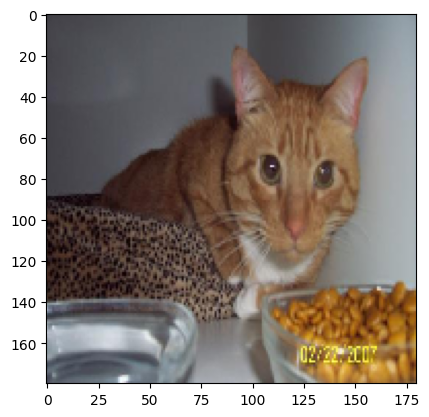

In [16]:
img = keras.utils.load_img("PetImages/Cat/6778.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize The Evaluation Matrices

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 
✅ Evaluation Metrics:
Accuracy       : 0.9485
Precision      : 0.9243
Recall         : 0.9780
F1-Score       : 0.9504
AUC-ROC        : 0.9922

Classification Report:
              precision    recall  f1-score   support

           0     0.9762    0.9186    0.9465      2321
           1     0.9243    0.9780    0.9504      2361

    accuracy                         0.9485      4682
   macro avg     0.9503    0.9483    0.9485      4682
weighted avg    

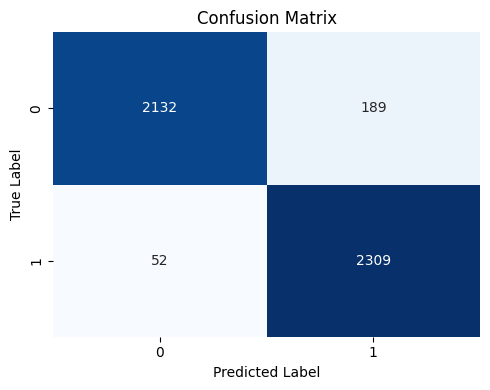

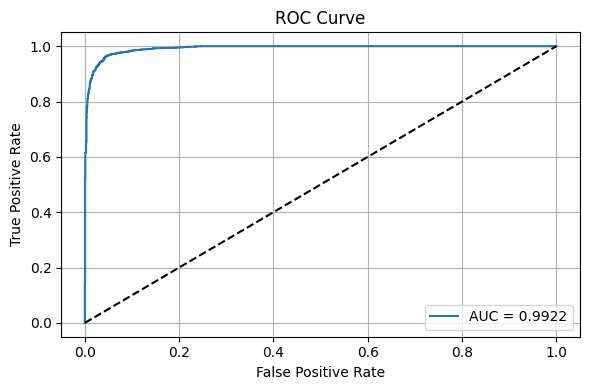

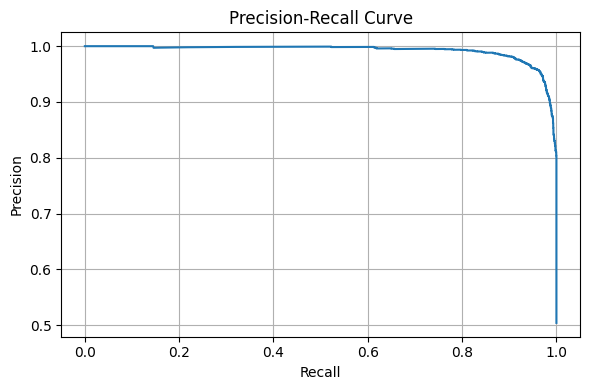

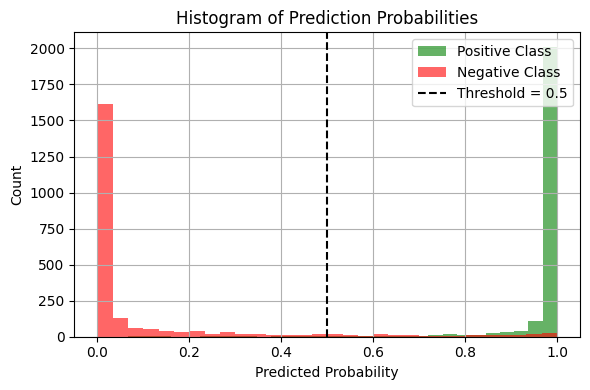

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    classification_report
)

# Collect true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(tf.sigmoid(preds).numpy().flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs >= 0.5).astype(int)

# --- 1. Print Metrics ---
print("✅ Evaluation Metrics:")
print(f"Accuracy       : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision      : {precision_score(y_true, y_pred):.4f}")
print(f"Recall         : {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score       : {f1_score(y_true, y_pred):.4f}")
print(f"AUC-ROC        : {roc_auc_score(y_true, y_pred_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# --- 2. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- 3. ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Probability Histogram ---
plt.figure(figsize=(6, 4))
plt.hist(y_pred_probs[y_true == 1], bins=30, alpha=0.6, label="Positive Class", color='green')
plt.hist(y_pred_probs[y_true == 0], bins=30, alpha=0.6, label="Negative Class", color='red')
plt.axvline(0.5, color='black', linestyle='--', label="Threshold = 0.5")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Histogram of Prediction Probabilities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
